# Newton's Method

The Newton-Raphson method for root-finding requires us to evaluate the derivative of the function in question. In order to do this in general, we can use a derivative approximation. Approximations exist for any desired level of accuracy. In this case, we use a first-order accurate forward difference method for simplicity: $f'(x) \approx \frac{f(x + \epsilon) - f(x)}{\epsilon}$

In [1]:
function derivative(f, epsilon=1e-9)
    x -> (f(x + epsilon) - f(x)) / epsilon
end

function newton_raphson(f, x0, max=1000, tol=1e-9)
    guess = x0
    df = derivative(f)
    
    for i in 1:max
        error = abs(f(guess))
        if error < tol
            return guess
        end
        
        guess = guess - f(guess) / df(guess)
    end
    
    return guess
end

newton_raphson (generic function with 3 methods)

Let's test this on the function $f(x) = xe^{-x}$, which has one zero at $x=0$. For positive initial guesses, the algorithm begins to diverge around $x = 1$. The zero approximations are clamped between -10 and 10 so that small values are visible when plotting.

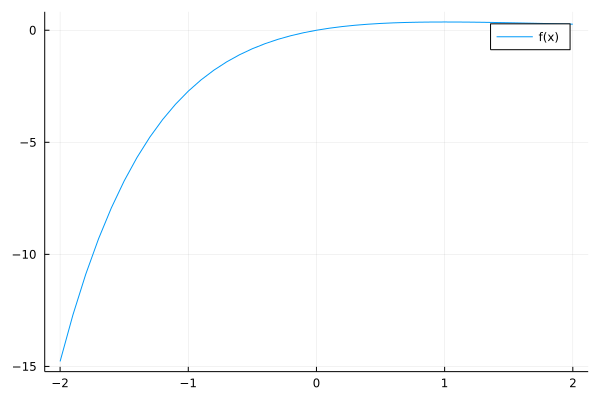

In [2]:
using Plots

f(x) = x * exp(-x)
domain = -2:0.1:2
plot(domain, f, label="f(x)")

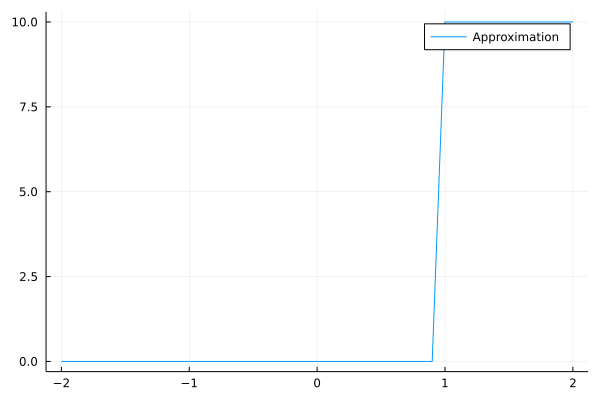

In [3]:
plot(domain, clamp.(newton_raphson.(f, domain), -10, 10), label="Approximation")

# Secant Method

The secant method does not require a derivative approximation. Instead, it makes use of two inital guesses. The zero of a secant line made by these points is computed, and then used as the next step in the method.

In [4]:
function secant(f, x0, x1, max=1000, tol=1e-9)
    if x0 > x1
        return secant(f, x1, x0, max, tol)
    end
    
    zero = x0
    
    for _ in 1:max
        err = abs(f(zero))
        
        if err < tol
            return zero
        end
        
        fx0, fx1 = f(x0), f(x1)
        zero = x1 - fx1 * (x1 - x0) / (fx1 - fx0)
        
        x0 = x1
        x1 = zero
    end
    
    return zero
end

secant (generic function with 3 methods)

Below, the method's results are plotted for various initial guesses. One initial guess is fixed, such as -1 or 1/2, while the other varies between -2 and 2. Like with Newton's Method, the algorithm begins diverging near $x = 1$.

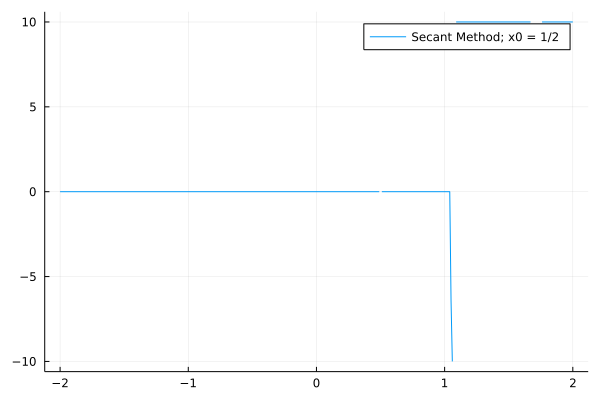

In [5]:
domain = -2:.01:2
plot(domain, clamp.(secant.(f, 1/2, domain), -10, 10), label="Secant Method; x0 = 1/2")

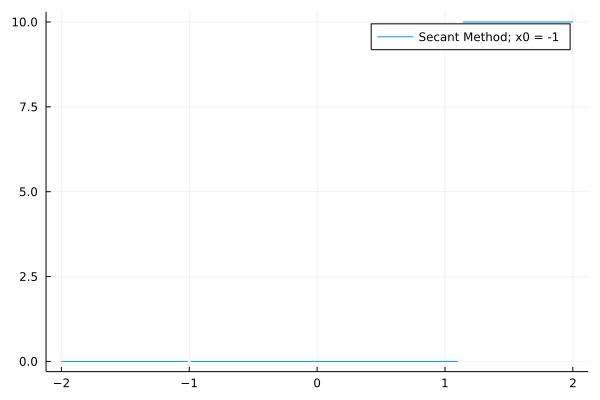

In [6]:
plot(domain, clamp.(secant.(f, -1, domain), -10, 10), label="Secant Method; x0 = -1")

# Tabulation
These functions can be easily modified to tabulate intermediate results:

In [7]:
function newton_raphson_tab(f, x0, max=1000, tol=1e-9)
    df = derivative(f)
    
    tab = Matrix(undef, 0, 3)
    guess = x0
    
    for i in 1:max
        error = abs(f(guess))
        tab = [tab; i guess error]
        
        if error < tol
            return tab
        end
        
        guess = guess - f(guess) / df(guess)
    end
    
    return tab
end

newton_raphson_tab (generic function with 3 methods)

In [8]:
function secant_tab(f, x0, x1, max=1000, tol=1e-9)
    if x0 > x1
        return secant(f, x1, x0, max, tol)
    end
    
    tab = Matrix(undef, 0, 3)
    zero = x0
    
    for i in 1:max
        err = abs(f(zero))
        tab = [tab; i zero err]
        
        if err < tol
            return tab
        end
        
        fx0, fx1 = f(x0), f(x1)
        zero = x1 - fx1 * (x1 - x0) / (fx1 - fx0)
        
        x0 = x1
        x1 = zero
    end
    
    return tab
end

secant_tab (generic function with 3 methods)

This allows us to graph the error over each iteration of our methods:

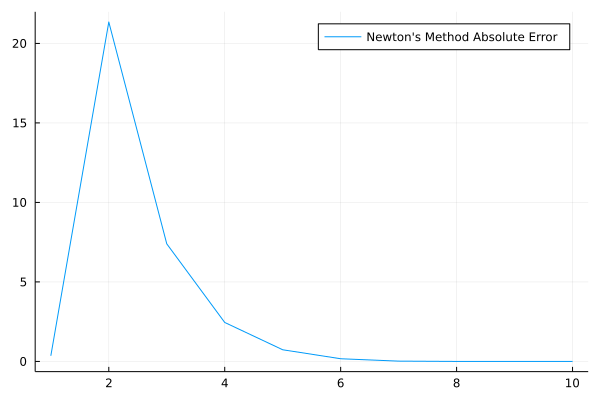

In [9]:
tab = newton_raphson_tab(f, 3/4)
plot(tab[:, 3], label="Newton's Method Absolute Error")

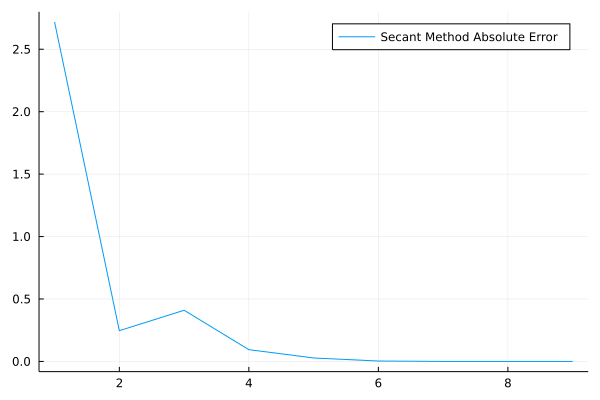

In [10]:
tab = secant_tab(f, -1, 1/2)
plot(tab[:, 3], label="Secant Method Absolute Error")

# Hybrid Method: Bisection + Newton's Method

Given an interval that contains a zero, we can use the bisection method to get arbitrarily close to a zero with logarithmic error. We can then define a hybrid method that narrows an interval to some threshold, afterwards switching to the Newton-Raphson method for the final approximation:

In [11]:
function bisection(f, a, b, tol=1e-6)
    k = ceil(-log2(tol/(b-a)))
    
    for i in 1:k
        midpoint = (a + b) / 2
        fa, fm, fb = f.([a, midpoint, b])
        
        if fa * fm < 0
            b = midpoint
        elseif fm * fb < 0
            a = midpoint
        else
            error(string("Could not locate zero in interval ", a, ", ", b))
        end
    end
    
    # Ensure we achieved desired accuracy
    @assert b - a < tol
    
    (a + b) / 2
end

function hybrid_bn(f, a, b, threshold=1e-3, max=1000, tol=1e-9)
    bisection_approx = bisection(f, a, b, threshold)
    newton_raphson(f, bisection_approx, max, tol)
end

hybrid_bn (generic function with 4 methods)

Consider the function $10.14 e^{x^2} \cos(\frac{\pi}{x})$. As a magnified oscillation, there are infinite zeros near $x = 0$. Outside of this neighborhood, the values of the function quickly skyrocket. It has a singularity at $x = 0$.

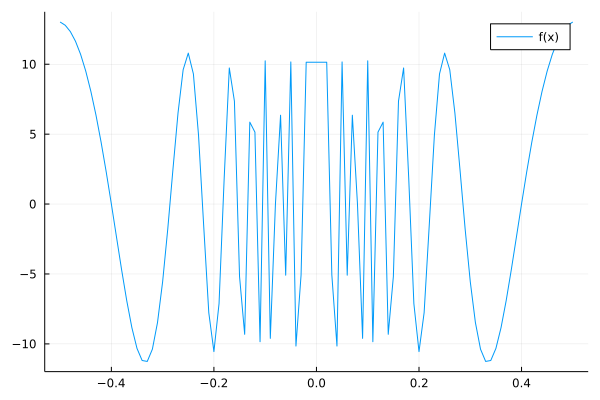

In [12]:
f(x) = 10.14 * exp(x^2) * cos(pi/x)
domain = filter((!=)(0), -.5:.01:.5)
plot(domain, f, label="f(x)")

We can find intervals with zeros by checking a set of points, and determining if the sign of the function changes. Below, 8 intervals are identified in this way inside $[-3, 7]$. The hybrid method is then used to identify the exact values of the roots.

In [13]:
different_sign(f, x, y) = sign(f(x)) != sign(f(y))
candidates(domain) = [x for (x, y) in zip(domain, domain[2:end]) if different_sign(f, x, y)]
guesses = filter((!=)(0), -3:.1:7) |> candidates

8-element Vector{Float64}:
 -2.0
 -0.7
 -0.4
 -0.2
  0.1
  0.3
  0.6
  1.9

In [14]:
zeros = [hybrid_bn(f, x0 - 1/4, x0 + 1/4) for x0 in guesses]

8-element Vector{Float64}:
 -2.0
 -0.6666666666666692
 -0.2222222222222222
 -0.3999999999999574
 -0.07407407407407407
  0.2857142857142776
  0.3999999999999584
  2.000000000000006

In [15]:
f.(zeros)

8-element Vector{Float64}:
  3.389976898647072e-14
 -2.838285053326612e-13
  5.870944320336171e-15
 -9.952157504096268e-12
  3.7477660626258826e-14
  3.435086057953903e-12
 -9.719644113243462e-12
  2.738348724744442e-12

# Hybrid Method: Bisection + Secant

This hybrid method hands off to the Secant method instead of Newton-Raphson. Because the Secant method requires an initial interval, the bisection method is modified to pass along its final interval.

In [16]:
function hybrid_bs(f, a, b, threshold=1e-3, max=1000, tol=1e-9)
    k = ceil(-log2(threshold/(b-a)))
    
    for i in 1:k
        midpoint = (a + b) / 2
        fa, fm, fb = f.([a, midpoint, b])
        
        if fa * fm < 0
            b = midpoint
        elseif fm * fb < 0
            a = midpoint
        else
            error(string("Could not locate zero in interval ", a, ", ", b))
        end
    end
    
    # Ensure we achieved desired accuracy
    @assert b - a < threshold
    
    secant(f, a, b, max, tol)
end

hybrid_bs (generic function with 4 methods)

As with the other hybrid method, this can be used with a linear search to identify zeros in an interval.

In [17]:
zeros = [hybrid_bs(f, x0 - 1/4, x0 + 1/4) for x0 in guesses]

8-element Vector{Float64}:
 -2.0
 -0.6666666666691082
 -0.22222222222222196
 -0.39999999999999986
 -0.07407407407403444
  0.28571428571428814
  0.40000000000000013
  2.0000000000000044

In [18]:
f.(zeros)

8-element Vector{Float64}:
  3.389976898647072e-14
 -2.7293404767268134e-10
 -1.6444578870714915e-13
 -2.806323087850082e-14
  2.313558019033872e-10
 -1.0405654221179372e-12
  3.534951208135927e-14
  2.0007717368104355e-12